# Value Function Iteration

In [1]:
using Interpolations
using Optim
using LinearAlgebra

const β = 0.96
const α = 0.4

f(k) = k^α
u(c) = c ≥ 0.0 ? log(c) : -1e10

u (generic function with 1 method)

In [2]:
const kmin = 1e-3;
const kmax = 100.0;
const nk = 1_001;
const kgrid = range(kmin, kmax, length=nk)

0.001:0.099999:100.0

In [4]:
function bellman_operator(valueV_old::Vector{Float64})
    valueF_old = LinearInterpolation(kgrid, valueV_old)
    valueV_new = zeros(length(kgrid))
    polV_new = zeros(length(kgrid))
    
    for i in eachindex(kgrid)
        k = kgrid[i]
        results = optimize(k′ -> -u(f(k) - k′) - β * valueF_old(k′), kmin, f(k))
        valueV_new[i] = -results.minimum
        polV[i] = results.minimizer
    end

    return valueV_new, polV
end

bellman_operator (generic function with 1 method)

In [5]:
iiter = 0;
max_iter = 600;
tol = 1e-8;

polV = zeros(length(kgrid))
valueV_old = u.(f.(kgrid))

@time while iiter < max_iter
    iiter += 1

    valueV_new, polV_new = bellman_operator(valueV_old)

    diff = norm(valueV_new - valueV_old, Inf)
    if iiter % 50 == 0
        println("Iteration: $iiter, Error: $diff")
    end
    
    valueV_old = copy(valueV_new)
    
    if diff < tol
        break
    end
end

Iteration: 50, Error: 0.1485055792413732
Iteration: 100, Error: 0.019288765160403898
Iteration: 150, Error: 0.0025053367784444447
Iteration: 200, Error: 0.0003254077133512112
Iteration: 250, Error: 4.226590398559438e-5
Iteration: 300, Error: 5.489794297375283e-6
Iteration: 350, Error: 7.132181067959209e-7
Iteration: 400, Error: 9.284469371095838e-8
Iteration: 450, Error: 1.2260393589258456e-8
  0.693915 seconds (2.22 M allocations: 123.434 MiB, 3.73% gc time, 23.20% compilation time: 2% of which was recompilation)


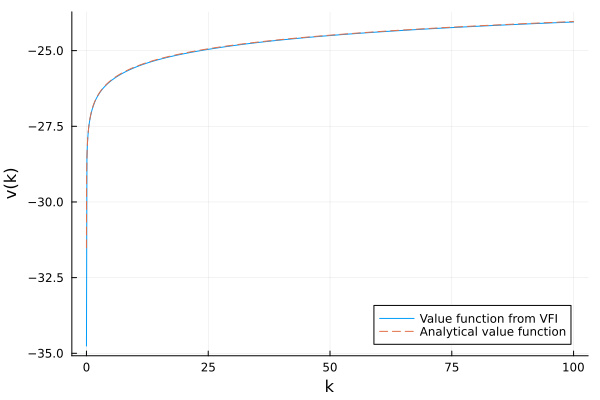

In [6]:
function v_analytical(k::Float64)
    return log(1 - α * β) / (1 - β) + (α * log(α * β)) / (1 - α)*(1 / (1 - β) - 1 / (1 - α * β)) + 1 / (1 - α * β) * log(k^α)
end

using Plots

value_F = LinearInterpolation(kgrid, valueV_old)
kfine_V = range(kmin, kmax, length = 5_001)

plot(kfine_V, value_F.(kfine_V),
    label = "Value function from VFI",
    xlabel = "k", ylabel = "v(k)")

plot!(kfine_V, v_analytical.(kfine_V),
    label = "Analytical value function",
    linestyle = :dash)

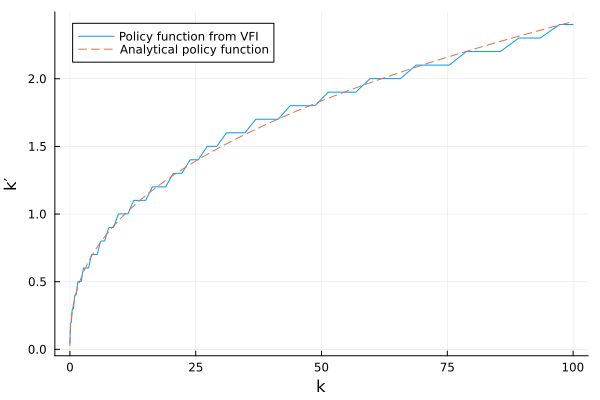

In [7]:
pol_F = LinearInterpolation(kgrid, polV)

plot(kfine_V, pol_F.(kfine_V),
    label = "Policy function from VFI",
    xlabel = "k", ylabel = "k′")

pol_F_analytical(k::Float64) = α * β * k^α

plot!(kfine_V, pol_F_analytical.(kfine_V),
    label = "Analytical policy function",
    linestyle = :dash)

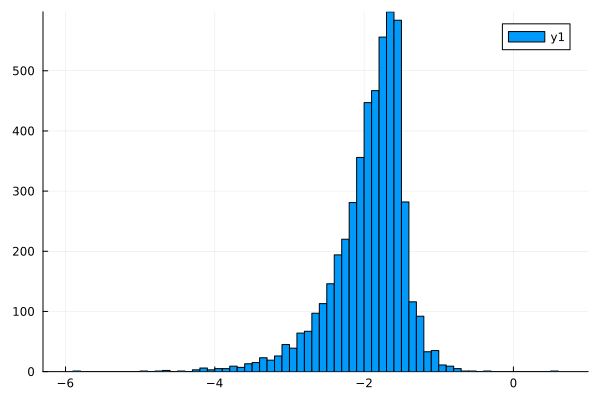

In [8]:
using Statistics

u_c = c -> c ≥ 0.0 ? 1/c : -1e10

u_c_inv = c -> c ≥ 0.0 ? 1/c : -1e10

function f_k(k::Float64)
    return α * k^(α - 1)
end

function compute_euler_residual(k::Float64)
    k′ = pol_F(k)
    c = f(k) - k′
    k′′ = pol_F(k′)
    c′ = f(k′) - k′′
    RHS = β * f_k(k′) * u_c(c′)
    return log10(abs(1 - (u_c_inv(RHS)/c)))
end

errors_V = compute_euler_residual.(kfine_V)

histogram(errors_V)

In [9]:
mean(errors_V)

-1.9358814855090303

In [12]:
10^(-mean(errors_V))

86.27430819393427